In [5]:
import numpy as np
import networkx as nx
import sys
from itertools import product
from variationaltoolkit import VarForm
from variationaltoolkit.utils import mact, get_max_independent_set_operator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from variationaltoolkit import VariationalQuantumOptimizerSequential

# Let's solve maximum independent set on this graph

$G = K_{2,3}$

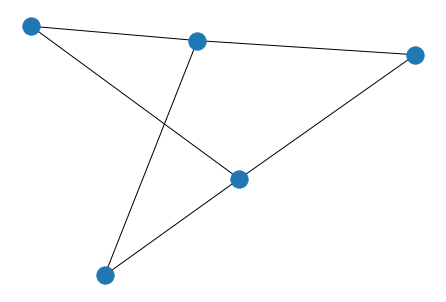

In [6]:
elist = [[0,2],[0,4],[1,2],[1,4],[0,3],[1,3]]
G = nx.OrderedGraph()
G.add_edges_from(elist)
vertex_num = G.number_of_nodes()
w = nx.adjacency_matrix(G, nodelist=range(vertex_num))
nx.draw(G)

In [16]:
def obj(x):
    return -sum(x)

# Set level to INFO to print optimization progress
import logging
from variationaltoolkit.utils import set_log_level
set_log_level(logging.INFO)

# Generate cost Hamiltonian
C, offset = get_max_independent_set_operator(vertex_num)

# First, allocate registers
qu = QuantumRegister(vertex_num)
ancilla_for_multi_toffoli = QuantumRegister(vertex_num - 2)
ancilla_for_rx = QuantumRegister(1)
cu = ClassicalRegister(vertex_num)

# Mixer circuit
beta = Parameter('beta')
mixer_circuit = QuantumCircuit(qu, ancilla_for_multi_toffoli, ancilla_for_rx, cu)
for u in G.nodes():
    mixer_circuit.barrier()
    mact(mixer_circuit, list(qu[x] for x in G.neighbors(u)), ancilla_for_rx, ancilla_for_multi_toffoli)

    mixer_circuit.mcrx(2 * beta, ancilla_for_rx, qu[u])
    mixer_circuit.barrier()

    mact(mixer_circuit, list(qu[x] for x in G.neighbors(u)), ancilla_for_rx, ancilla_for_multi_toffoli)

# Measurement circuit 
measurement_circuit = QuantumCircuit(qu, ancilla_for_multi_toffoli, ancilla_for_rx, cu)
measurement_circuit.measure(qu, cu)

# For the purposes of this example, I've precomputed a good initial point
# You can pass None and it'll generate a random one for you
initial_point = np.array([ 6.04102059,  3.74579808, -5.50077232, -3.18254589, -0.61572468,
         4.51305444, -0.47617092,  5.97028743,  2.51725288, -2.20904592,
        -5.38950718,  2.09493441,  1.23907814, -1.45952838, -3.57838767,
        -3.66236095, -2.67445383,  3.00190345,  2.84712677,  5.13521998])

# pass it all to VariationalQuantumOptimizer
varopt = VariationalQuantumOptimizerSequential(
    obj,
    'COBYLA',
    initial_point=initial_point,
    optimizer_parameters={'maxiter':1000},
    backend_description={'package':'qiskit', 'provider':'Aer', 'name':'qasm_simulator'},
    problem_description={'offset': offset},
    varform_description={
        'name':'QAOA',
        'p':10,
        'cost_operator':C,
        'num_qubits':vertex_num, 'use_mixer_circuit':True,
        'mixer_circuit':mixer_circuit,
        'measurement_circuit': measurement_circuit,
        'qregs':[qu, ancilla_for_multi_toffoli, ancilla_for_rx, cu]
    },
    execute_parameters={'shots': 5000}
    )
res = varopt.optimize()

[2020-04-03 13:45:01,052] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 0, objective: -2.563 at point [ 6.04102059  3.74579808 -5.50077232 -3.18254589 -0.61572468  4.51305444
 -0.47617092  5.97028743  2.51725288 -2.20904592 -5.38950718  2.09493441
  1.23907814 -1.45952838 -3.57838767 -3.66236095 -2.67445383  3.00190345
  2.84712677  5.13521998]
[2020-04-03 13:45:03,515] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 1, objective: -0.7906 at point [ 7.04102059  3.74579808 -5.50077232 -3.18254589 -0.61572468  4.51305444
 -0.47617092  5.97028743  2.51725288 -2.20904592 -5.38950718  2.09493441
  1.23907814 -1.45952838 -3.57838767 -3.66236095 -2.67445383  3.00190345
  2.84712677  5.13521998]
[2020-04-03 13:45:05,886] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 2, objective: -1.6176 at point [ 6.04102059  4.745

[2020-04-03 13:45:51,859] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 21, objective: -1.7808 at point [ 5.59592513  3.5083837  -5.77942157 -3.41207492 -0.93068673  4.27589118
 -0.70208374  5.78912524  2.34267019 -2.56981332 -5.39935131  2.01201265
  1.04646461 -1.62250906 -3.75236766 -3.75422279 -2.84823292  2.82717008
  2.67796839  5.00649287]
[2020-04-03 13:45:54,330] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 22, objective: -2.1228 at point [ 5.81847286  3.62709089 -5.64009694 -3.29731041 -0.7732057   4.39447281
 -0.58912733  5.87970633  2.42996153 -2.38942962 -5.39442925  2.05347353
  1.14277137 -1.54101872 -3.66537767 -3.70829187 -2.76134338  2.91453677
  2.76254758  5.07085642]
[2020-04-03 13:45:56,705] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 23, objective: -2.0898 at point [ 6.27396406  3

[2020-04-03 13:46:42,727] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 42, objective: -2.5426 at point [ 6.03685066  3.73337833 -5.49741033 -3.19574619 -0.61408446  4.50035964
 -0.47219598  5.95742774  2.52101727 -2.21577664 -5.37805245  1.99074016
  1.28374833 -1.45966138 -3.57852965 -3.66243592 -2.67459565  3.00176085
  2.84698872  5.25603647]
[2020-04-03 13:46:45,201] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 43, objective: -2.3526 at point [ 5.99271135  3.79973459 -5.50328219 -3.15029992 -0.61602457  4.5890122
 -0.53343024  6.07282741  2.50140772 -2.16190297 -5.50769835  1.84815859
  1.31391924 -1.47322677 -3.57288493 -3.67083179 -2.68311811  2.98302469
  2.85727672  5.17156816]
[2020-04-03 13:46:47,581] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 44, objective: -2.5276 at point [ 5.97856982  3.

[2020-04-03 13:47:31,214] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 62, objective: -2.5618 at point [ 6.04152792  3.77451373 -5.42422719 -3.18557029 -0.56795038  4.45930943
 -0.50100802  5.9544363   2.53114766 -2.12549571 -5.37248624  1.98669765
  1.27159858 -1.46714215 -3.58500341 -3.66615753 -2.68319078  2.99291181
  2.84144289  5.12803418]
[2020-04-03 13:47:33,679] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 63, objective: -2.5792 at point [ 6.04636735  3.75044828 -5.43202969 -3.21555441 -0.5944325   4.44707828
 -0.50694822  5.93598574  2.50688145 -2.13757551 -5.38702527  1.97765361
  1.26381377 -1.48741199 -3.59045833 -3.68399652 -2.69743821  2.97587815
  2.84210503  5.10953958]
[2020-04-03 13:47:36,056] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 64, objective: -2.5642 at point [ 6.01893307  3

[2020-04-03 13:48:22,134] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 83, objective: -2.5694 at point [ 6.01527344  3.763271   -5.42752414 -3.19610489 -0.57142422  4.4691806
 -0.50532353  5.94793576  2.52510421 -2.13715704 -5.37174571  1.98784005
  1.2658713  -1.47204549 -3.58470539 -3.66501774 -2.68080166  2.98284826
  2.83004715  5.12739357]
[2020-04-03 13:48:24,602] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 84, objective: -2.5544 at point [ 6.01748638  3.76684795 -5.42943193 -3.19512393 -0.57668655  4.4569441
 -0.50405903  5.94690991  2.52424753 -2.13410967 -5.37348872  1.98800663
  1.27456391 -1.47204538 -3.58642909 -3.66531889 -2.67845795  2.98459057
  2.82857072  5.12801699]
[2020-04-03 13:48:26,980] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 85, objective: -2.5742 at point [ 6.0156249   3.7

[2020-04-03 13:49:13,051] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 104, objective: -2.5848 at point [ 6.01572027  3.77528005 -5.42935192 -3.19902788 -0.58908067  4.46034846
 -0.49895772  5.94846053  2.52537127 -2.13407308 -5.37432225  1.9833516
  1.2672305  -1.47450515 -3.59244216 -3.67282597 -2.67066303  2.9844047
  2.82354437  5.13610781]
[2020-04-03 13:49:15,526] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 105, objective: -2.5714 at point [ 6.0158984   3.77427841 -5.42959497 -3.19427059 -0.59034754  4.45939555
 -0.49821253  5.94891682  2.52710818 -2.13239559 -5.37339612  1.98377202
  1.26766176 -1.47523372 -3.59063013 -3.67567671 -2.67546805  2.98378298
  2.82542093  5.13429039]
[2020-04-03 13:49:17,905] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 106, objective: -2.5656 at point [ 6.01663892  

[2020-04-03 13:50:01,598] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 124, objective: -2.5848 at point [ 6.01674159  3.77519424 -5.42827082 -3.19449674 -0.59050199  4.45956472
 -0.49910272  5.94839685  2.52639019 -2.13318254 -5.37440474  1.98453618
  1.26649323 -1.47471889 -3.59004505 -3.6741543  -2.67401078  2.98508085
  2.82724599  5.13435419]
[2020-04-03 13:50:04,025] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 125, objective: -2.5846 at point [ 6.01592651  3.77517288 -5.42869998 -3.19462663 -0.59126677  4.45876071
 -0.49928116  5.94817162  2.526157   -2.13337769 -5.37349217  1.98346693
  1.26694821 -1.47483259 -3.59047295 -3.67423277 -2.67392023  2.98516873
  2.82699256  5.13417892]
[2020-04-03 13:50:06,511] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 126, objective: -2.5796 at point [ 6.01549236

[2020-04-03 13:50:50,146] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 144, objective: -2.5738 at point [ 6.01577879  3.7754274  -5.42818876 -3.19448803 -0.59016529  4.45896117
 -0.49957667  5.94817147  2.52610338 -2.1335603  -5.37313097  1.9836507
  1.26687557 -1.47494519 -3.59042778 -3.67481821 -2.67384442  2.9851165
  2.82721652  5.13426312]
[2020-04-03 13:50:52,523] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 145, objective: -2.5778 at point [ 6.01575309  3.77518518 -5.42849841 -3.19473688 -0.59054238  4.45923844
 -0.49941877  5.94838856  2.52584492 -2.13364049 -5.37338051  1.9835271
  1.26655158 -1.47501555 -3.59027976 -3.67437038 -2.67413205  2.98497616
  2.82697191  5.13394853]
[2020-04-03 13:50:54,988] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 146, objective: -2.5718 at point [ 6.01577763  3

[2020-04-03 13:51:38,658] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 164, objective: -2.57 at point [ 6.01583073  3.7750908  -5.42850514 -3.1946515  -0.59056115  4.4591882
 -0.49946543  5.9482067   2.52615829 -2.13377689 -5.37342525  1.98356262
  1.26670678 -1.47507463 -3.59038333 -3.67443633 -2.67415029  2.98498296
  2.82700377  5.13414703]
[2020-04-03 13:51:41,131] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 165, objective: -2.585 at point [ 6.01588077  3.7751319  -5.42850891 -3.19463639 -0.5905508   4.45915205
 -0.49946971  5.94819815  2.52612787 -2.13375675 -5.37342032  1.98355558
  1.26667372 -1.47512382 -3.59037455 -3.67443811 -2.67413342  2.9849847
  2.82698853  5.13411477]
[2020-04-03 13:51:43,509] {/home/rshaydu/quantum/variationaltoolkit/variationaltoolkit/objectivewrapper.py:79} INFO - called at step 166, objective: -2.565 at point [ 6.01587314  3.77

# Let's look at the optimal parameters and how long it took us to find them

In [19]:
print(res)

{'num_optimizer_evals': 182, 'min_val': -2.5846, 'opt_params': array([ 6.01587436,  3.77513361, -5.42850721, -3.19463039, -0.59058585,
        4.45918678, -0.4994869 ,  5.94819352,  2.52615944, -2.13379859,
       -5.37343216,  1.98353572,  1.26663717, -1.4750866 , -3.59039644,
       -3.67441351, -2.67411871,  2.98496707,  2.82696737,  5.13406614])}


In [18]:
optimum = varopt.get_optimal_solution()
print(f"Found optimal solution: {optimum}")

# Check that the optimal solution is feasible
for i, j in product(set(np.where(reversed(optimum))[0]), repeat=2):
    if i != j:
        try:
            assert(not G.has_edge(i,j))
        except AssertionError as e:
            print(i,j,x)
            raise e

Found optimal solution: (-3, array([1, 1, 1, 0, 0]))
